In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('brown')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter
import string
string.punctuation
import re
from textblob import TextBlob
import gensim.downloader as api

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
df = pd.read_csv('redmi6.csv', encoding='ISO-8859-1')
df.head()

,Review Title,Customer name,Rating,Date,Category,Comments,Useful
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,on 1 October 2018,Display,Another Midrange killer Smartphone by Xiaomi\n...,
1,vry small size mobile,Raza ji,3.0 out of 5 stars,on 15 September 2018,Others,All ok but vry small size mobile,7 people found this helpful
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,on 18 September 2018,Others,Quite good,7 people found this helpful
3,Value for Money,Amazon Customer,5.0 out of 5 stars,on 28 September 2018,Display,Redmi has always have been the the king of bud...,2 people found this helpful
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,on 18 September 2018,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful


In [3]:
data = df[['Rating', 'Comments']].reset_index(drop=True)
data.head()

,Rating,Comments
0,4.0 out of 5 stars,Another Midrange killer Smartphone by Xiaomi\n...
1,3.0 out of 5 stars,All ok but vry small size mobile
2,3.0 out of 5 stars,Quite good
3,5.0 out of 5 stars,Redmi has always have been the the king of bud...
4,2.0 out of 5 stars,worst product from MI. I am a hardcore fan of ...


In [4]:
# in this case the same review with same class is repeated
data.duplicated().sum()

59

In [5]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [6]:
data.shape

(221, 2)

In [7]:
data["Comments"].duplicated().sum()

5

In [8]:
duplicated_data=data[data["Comments"].duplicated(keep=False)]
duplicated_data

,Rating,Comments
30,5.0 out of 5 stars,Good phone
32,4.0 out of 5 stars,Good
65,5.0 out of 5 stars,Nice
71,1.0 out of 5 stars,Ok
80,4.0 out of 5 stars,Good phone
114,5.0 out of 5 stars,Good
154,4.0 out of 5 stars,Nice
190,4.0 out of 5 stars,Nice mobile
191,5.0 out of 5 stars,Nice mobile
214,5.0 out of 5 stars,Ok


In [9]:
data["Comments"].drop_duplicates(keep=False,inplace=True)
data.shape

(221, 2)

In [10]:
data.columns = ['Rating', 'Comments']
data.head()

,Rating,Comments
0,4.0 out of 5 stars,Another Midrange killer Smartphone by Xiaomi\n...
1,3.0 out of 5 stars,All ok but vry small size mobile
2,3.0 out of 5 stars,Quite good
3,5.0 out of 5 stars,Redmi has always have been the the king of bud...
4,2.0 out of 5 stars,worst product from MI. I am a hardcore fan of ...


In [11]:
data.shape

(221, 2)

In [12]:
# Convert the textual ratings to numerical values
data['Rating'] = data['Rating'].str.extract(r'(\d+\.\d+)')  # Extract numerical ratings
data['Rating'] = data['Rating'].astype(float)  # Convert to float
data.head()

,Rating,Comments
0,4.0,Another Midrange killer Smartphone by Xiaomi\n...
1,3.0,All ok but vry small size mobile
2,3.0,Quite good
3,5.0,Redmi has always have been the the king of bud...
4,2.0,worst product from MI. I am a hardcore fan of ...


In [13]:
# Convert Rating to polarity labels
data['Polarity'] = data['Rating'].apply(lambda x: 1 if x >= 3 else 0)
data.head()

,Rating,Comments,Polarity
0,4.0,Another Midrange killer Smartphone by Xiaomi\n...,1
1,3.0,All ok but vry small size mobile,1
2,3.0,Quite good,1
3,5.0,Redmi has always have been the the king of bud...,1
4,2.0,worst product from MI. I am a hardcore fan of ...,0


In [14]:
value_counts=data.Polarity.value_counts()
value_counts

Polarity
1    182
0     39
Name: count, dtype: int64

<Axes: xlabel='Polarity'>

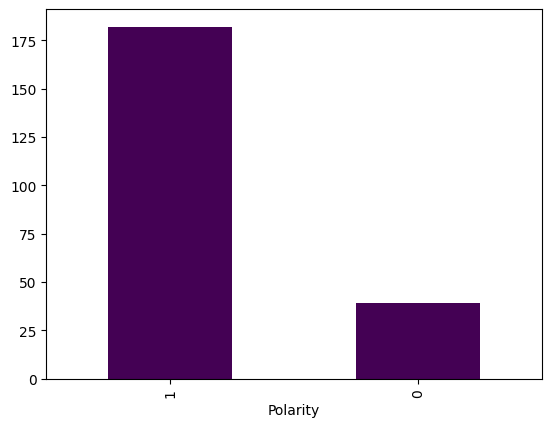

In [15]:
value_counts.plot(kind="bar",x=value_counts.keys,colormap='viridis')

In [16]:
# Count the null values
data.isnull().sum()

Rating      0
Comments    0
Polarity    0
dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 0 to 279
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rating    221 non-null    float64
 1   Comments  221 non-null    object 
 2   Polarity  221 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ KB


#### Data Cleaning

In [18]:
def lower(text):
    ## split the words of the sentence by split() to work with each word individually
    words = text.split()
    ## created a new list to save all the lowercase words and converted it by lower() method
    lower = [word.lower() for word in words]
    ## after finishing, join them back by join() method
    return ' '.join(lower)
## applying the function on the feature Review
data['Comments']= data['Comments'].apply(lambda x:lower(x))
data.head()

,Rating,Comments,Polarity
0,4.0,another midrange killer smartphone by xiaomi m...,1
1,3.0,all ok but vry small size mobile,1
2,3.0,quite good,1
3,5.0,redmi has always have been the the king of bud...,1
4,2.0,worst product from mi. i am a hardcore fan of ...,0


In [19]:
def hyperlinks(text):
    ## this pattern follows any url
    pattern = r'http\S+|www\S+'
    ## re.sub() is used for substituting all the links with spaces
    removed = re.sub(pattern, '', text)
    return removed
## applying the function on the feature Review
data['Comments']= data['Comments'].apply(lambda x:hyperlinks(x))
print("successfully removed hyperlinks")

successfully removed hyperlinks


In [21]:
def remove_large_spaces(text):
    ## this pattern is for tabs
    pattern = r'\s+'
    # Remove tabs using regex substitution with spaces
    removed_spaces = re.sub(pattern, ' ', text)
    ## the strip method is used to remove any leading spaces after substitution
    return removed_spaces.strip()
data['Comments']= data['Comments'].apply(lambda x:remove_large_spaces(x))
print("successfully removed large spaces")

successfully removed large spaces


In [22]:
# show the stopwords
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [23]:
def remove_stopwords(text):
    # checking if the word in the sentences contain stop words or not and save it
    text=' '.join([word for word in text.split() if word not in stopword])
    return text
data['Comments'] = data['Comments'].apply(lambda x: remove_stopwords(x))
print("successfully removed stopwords")

successfully removed stopwords


In [24]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the punctuation-free text
data['Comments']= data['Comments'].apply(lambda x:remove_punctuation(x))
print("successfully removed punctuation")

successfully removed punctuation


In [25]:
def remove_numbers(text):
    ## this pattern in special for numbers
    pattern = r'\d+'
    # Remove numbers using regex substitution with spaces
    removed_numbers = re.sub(pattern, '', text)
    return removed_numbers
data['Comments']= data['Comments'].apply(lambda x:remove_numbers(x))
print("successfully removed numbers")

successfully removed numbers


In [26]:
def remove_html(text):
    html_re = re.compile(r'<.*?>')
    # create regex for html tag
    text = re.sub(html_re, '', text)
    return text
data['Comments']= data['Comments'].apply(lambda x:remove_html(x))
print("successfully removed html tags")

successfully removed html tags


In [27]:
def remove_date_time(text):
    # this patterns match date and time formats
    # Matches MM/DD/YYYY or MM/DD/YY
    date_pattern = r"\d{1,2}/\d{1,2}/\d{2,4}"
    # Matches HH:MM or HH:MMAM/HH:MMPM
    time_pattern = r"\d{1,2}:\d{2}([AP]M)?"
    # Remove date and time patterns from the text
    text_without_date = re.sub(date_pattern, "", text)
    text_without_date_time = re.sub(time_pattern, "", text_without_date)
    return text_without_date_time
data['Comments']= data['Comments'].apply(lambda x:remove_date_time(x))
print("successfully removed data and time")

successfully removed data and time


In [28]:
def remove_mentions_hashtags(text):
    # Remove mentions
    text_without_mentions = re.sub(r"@\w+", "", text)
    # Remove hashtags
    text_without_mentions_hashtags = re.sub(r"#\w+", "", text_without_mentions)
    return text_without_mentions_hashtags
data['Comments']= data['Comments'].apply(lambda x:remove_mentions_hashtags(x))
print("successfully removed mentions and hashtags")

successfully removed mentions and hashtags


In [29]:
def stem_text(text):
  """Stems the text using PorterStemmer.

  Args:
      text: The text to be stemmed.

  Returns:
      The stemmed text.
  """
  stemmer = PorterStemmer()
  words = text.split()
  stemmed_text = " ".join([stemmer.stem(word) for word in words])
  return stemmed_text

data['Comments']= data['Comments'].apply(lambda x:stem_text(x))
print("successfully stemmed the text")

successfully stemmed the text


In [30]:
def tokenize_data(data):
    """
    Tokenize the input data using NLTK

    Args:
    data : str : The input text data

    Returns:
    tokens : list : List of tokens
    """
    tokens = word_tokenize(data)
    return tokens

data['Comments']= data['Comments'].apply(lambda x:tokenize_data(x))
print("successfully tokenized the text")

successfully tokenized the text


In [31]:
data

,Rating,Comments,Polarity
0,4.0,"[anoth, midrang, killer, smartphon, xiaomi, ma...",1
1,3.0,"[ok, vri, small, size, mobil]",1
2,3.0,"[quit, good]",1
3,5.0,"[redmi, alway, king, budget, segmentand, yet, ...",1
4,2.0,"[worst, product, mi, hardcor, fan, mi, one, re...",0
...,...,...,...
275,5.0,"[like, phone, awesom, look, design, use, phone]",1
276,4.0,"[product, avasom, invoic, note, includ]",1
277,3.0,"[redmi, note, note, proit, seem, older, model,...",1
278,5.0,"[love, mi]",1


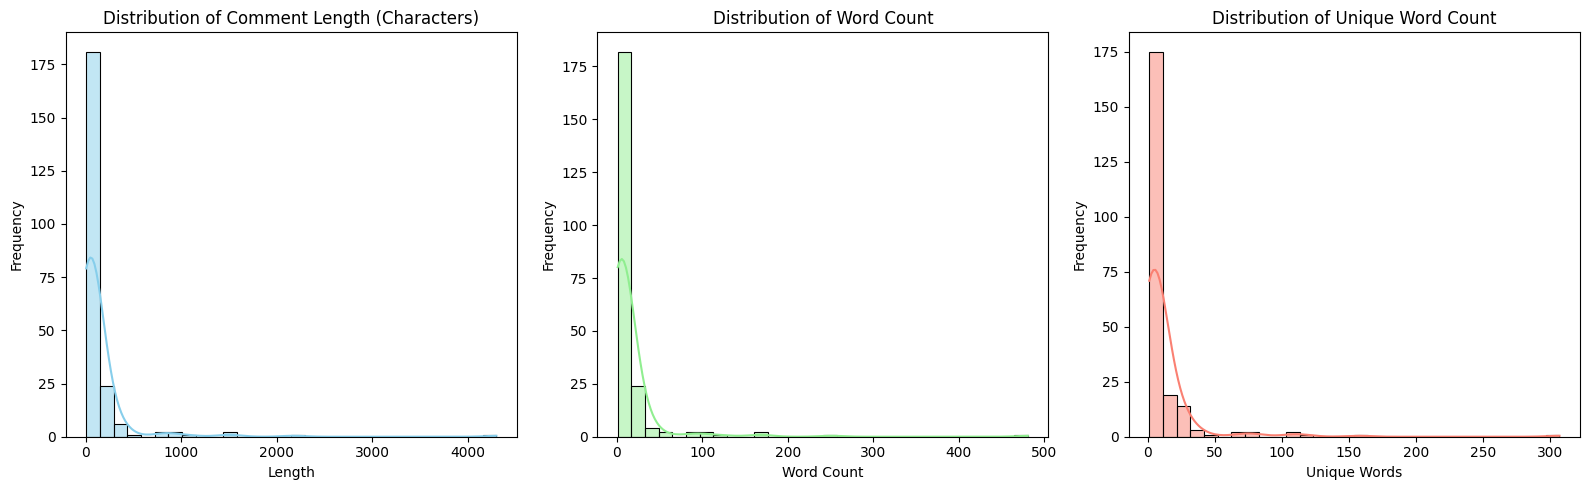

In [32]:
# Calculate basic text statistics
data['comment_length'] = data['Comments'].dropna().astype(str).apply(len)
data['word_count'] = data['Comments'].dropna().astype(str).apply(lambda x: len(x.split()))
data['unique_word_count'] = data['Comments'].dropna().astype(str).apply(lambda x: len(set(x.split())))

# Plot histograms
plt.figure(figsize=(16, 5))

# Comment length
plt.subplot(1, 3, 1)
sns.histplot(data['comment_length'], bins=30, color='skyblue', kde=True)
plt.title('Distribution of Comment Length (Characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Word count
plt.subplot(1, 3, 2)
sns.histplot(data['word_count'], bins=30, color='lightgreen', kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Unique word count
plt.subplot(1, 3, 3)
sns.histplot(data['unique_word_count'], bins=30, color='salmon', kde=True)
plt.title('Distribution of Unique Word Count')
plt.xlabel('Unique Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\2045474617.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Rating'], y=data['comment_length'], palette='Blues')
C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\2045474617.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Rating'], y=data['word_count'], palette='Greens')
C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\2045474617.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Rating'], y=data['unique_word_count'], palette='Reds')


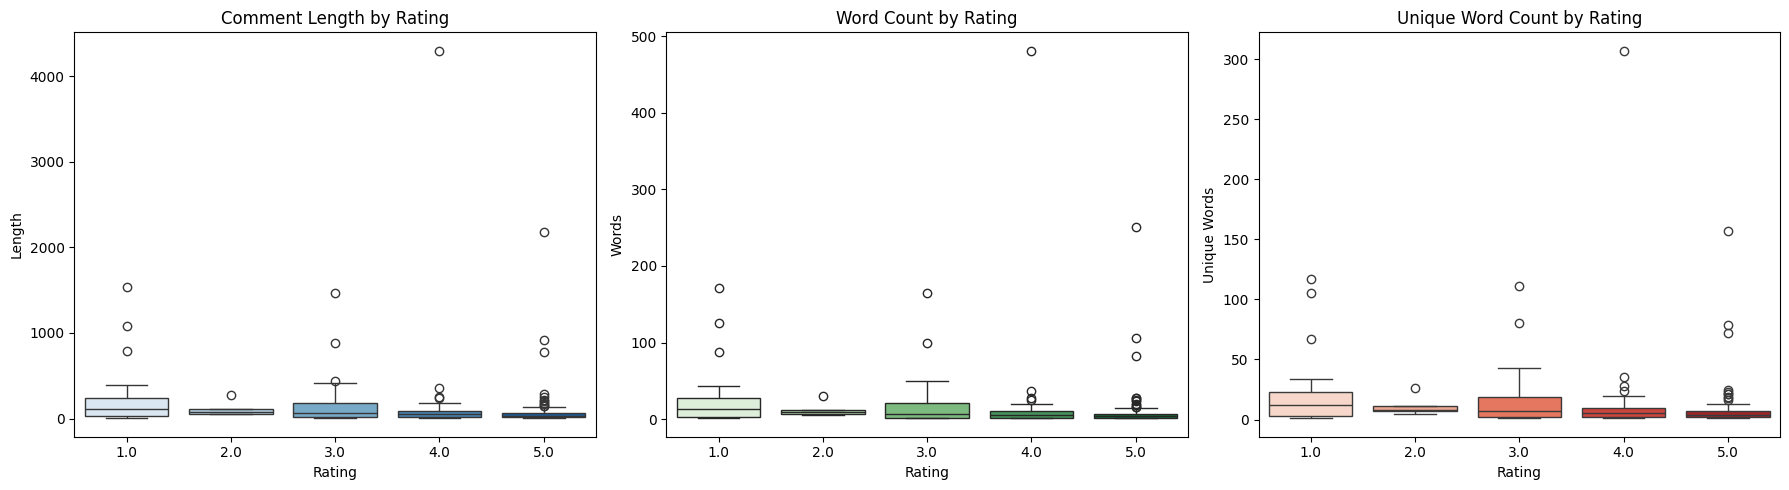

In [33]:
# Boxplots: comment stats vs. rating
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=data['Rating'], y=data['comment_length'], palette='Blues')
plt.title('Comment Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Length')

plt.subplot(1, 3, 2)
sns.boxplot(x=data['Rating'], y=data['word_count'], palette='Greens')
plt.title('Word Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Words')

plt.subplot(1, 3, 3)
sns.boxplot(x=data['Rating'], y=data['unique_word_count'], palette='Reds')
plt.title('Unique Word Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Unique Words')

plt.tight_layout()
plt.show()


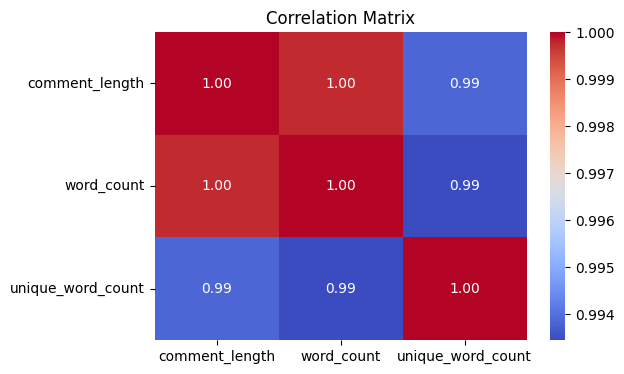

In [34]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
corr = data[['comment_length', 'word_count', 'unique_word_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [35]:
# Per-rating average stats
rating_stats = data.groupby('Rating')[['comment_length', 'word_count', 'unique_word_count']].mean().round(1)
print("Average Comment Stats by Rating:")
print(rating_stats)

Average Comment Stats by Rating:
        comment_length  word_count  unique_word_count
Rating                                               
1.0              212.1        23.8               19.7
2.0              113.4        12.6               11.4
3.0              204.8        23.1               18.3
4.0              176.9        19.7               15.2
5.0               79.6         8.9                7.5


Summary of Review Stats and Sentiment by Rating:
   Rating  comment_length  word_count  unique_word_count  sentiment_score
0     1.0          212.06       23.82              19.68            -0.01
1     2.0          113.40       12.60              11.40            -0.19
2     3.0          204.77       23.14              18.32             0.31
3     4.0          176.88       19.68              15.18             0.45
4     5.0           79.62        8.87               7.51             0.47


C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\1207212070.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='sentiment_score', data=summary, palette='coolwarm')


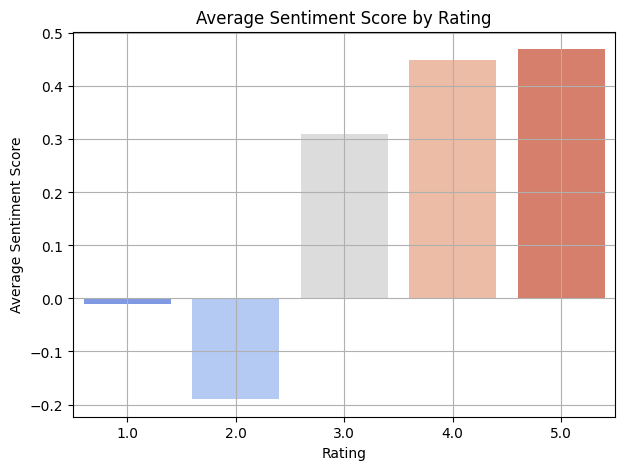

In [36]:
# Compute sentiment polarity for each comment
data['sentiment_score'] = data['Comments'].dropna().astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Group by rating and compute means
summary = data.groupby('Rating').agg({
    'comment_length': 'mean',
    'word_count': 'mean',
    'unique_word_count': 'mean',
    'sentiment_score': 'mean'
}).round(2).reset_index()

# Display summary table
print("Summary of Review Stats and Sentiment by Rating:")
print(summary)

# Plot sentiment score by rating
plt.figure(figsize=(7, 5))
sns.barplot(x='Rating', y='sentiment_score', data=summary, palette='coolwarm')
plt.title('Average Sentiment Score by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()


C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\184559629.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Rating', y='sentiment_score', palette='coolwarm')


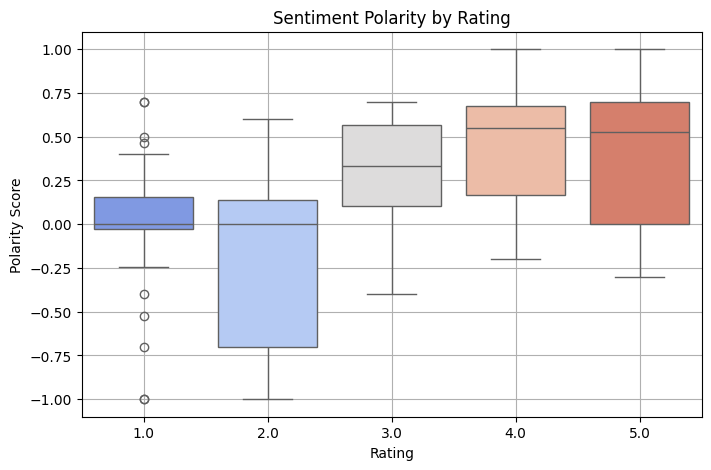

In [37]:
if 'sentiment_score' in data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x='Rating', y='sentiment_score', palette='coolwarm')
    plt.title('Sentiment Polarity by Rating')
    plt.xlabel('Rating')
    plt.ylabel('Polarity Score')
    plt.grid(True)
    plt.show()


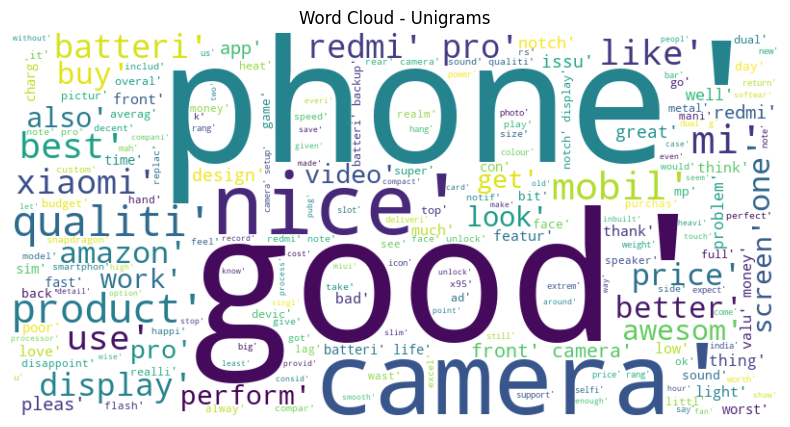

C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\4146396536.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_uni, x='frequency', y='word', palette='magma')


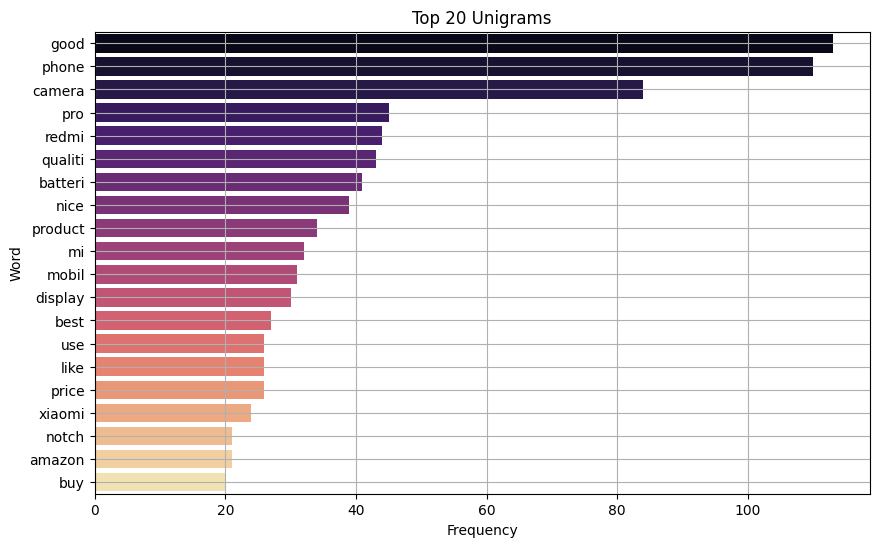

In [38]:
comments = data['Comments'].dropna().astype(str)

# Join all text
text_all = " ".join(comments)

# Word Cloud for Unigrams
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text_all)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Unigrams')
plt.show()

# Bar Chart - Top 20 Unigrams
vectorizer_uni = CountVectorizer(stop_words='english', max_features=20)
X_uni = vectorizer_uni.fit_transform(comments)
words = vectorizer_uni.get_feature_names_out()
counts = X_uni.sum(axis=0).A1
df_uni = pd.DataFrame({'word': words, 'frequency': counts}).sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_uni, x='frequency', y='word', palette='magma')
plt.title('Top 20 Unigrams')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.grid(True)
plt.show()

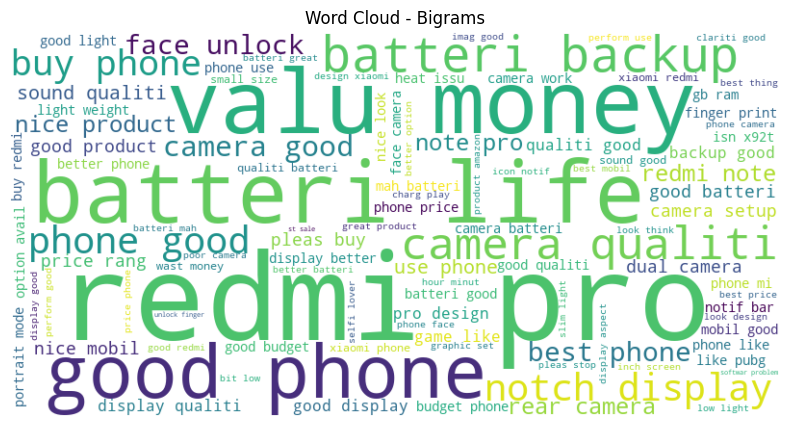

C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\4148472810.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bi, x='frequency', y='bigram', palette='magma')


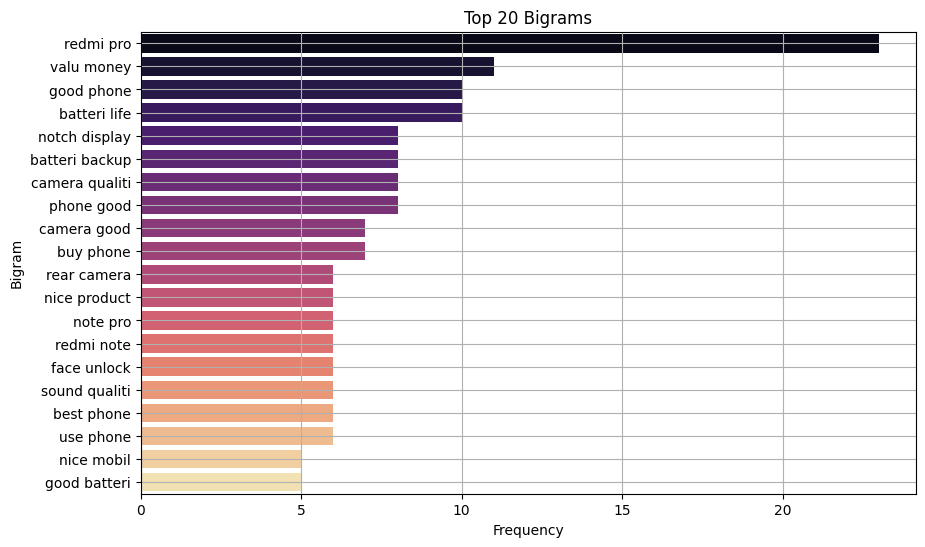

In [39]:
# Word Cloud for Bigrams
vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=100)
X_bi = vectorizer_bi.fit_transform(comments)
bigrams = vectorizer_bi.get_feature_names_out()
counts_bi = X_bi.sum(axis=0).A1
text_bigrams = dict(zip(bigrams, counts_bi))
wordcloud_bi = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text_bigrams)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bi, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bigrams')
plt.show()

# Bar Chart - Top 20 Bigrams
df_bi = pd.DataFrame({'bigram': bigrams, 'frequency': counts_bi}).sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_bi, x='frequency', y='bigram', palette='magma')
plt.title('Top 20 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.grid(True)
plt.show()

C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\3267210196.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_aspects, x='frequency', y='aspect', palette='viridis')


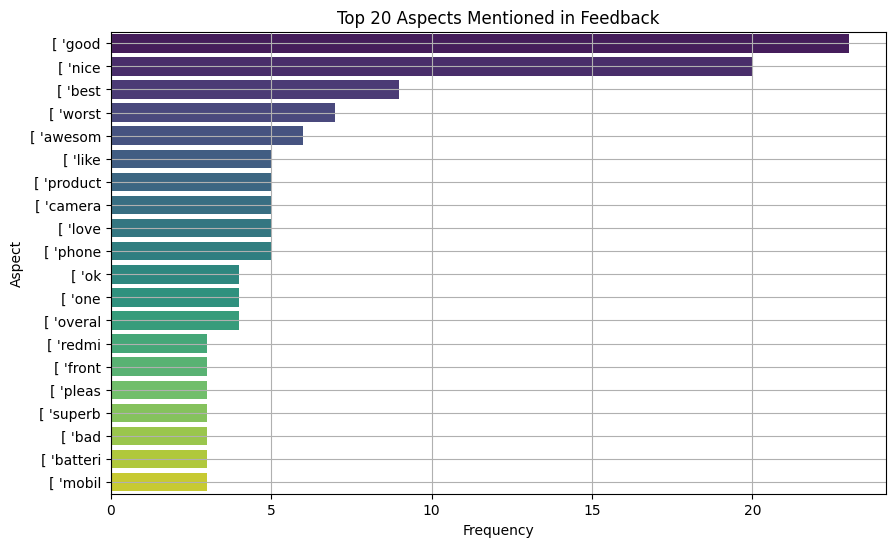

In [40]:
# Extract noun phrases (potential aspects/topics)
aspect_phrases = []

for comment in data['Comments'].dropna().astype(str):
    blob = TextBlob(comment)
    aspect_phrases.extend(blob.noun_phrases)

# Count the most frequent noun phrases
aspect_freq = Counter(aspect_phrases)
top_aspects = aspect_freq.most_common(20)

# Create DataFrame
df_aspects = pd.DataFrame(top_aspects, columns=['aspect', 'frequency'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_aspects, x='frequency', y='aspect', palette='viridis')
plt.title('Top 20 Aspects Mentioned in Feedback')
plt.xlabel('Frequency')
plt.ylabel('Aspect')
plt.grid(True)
plt.show()


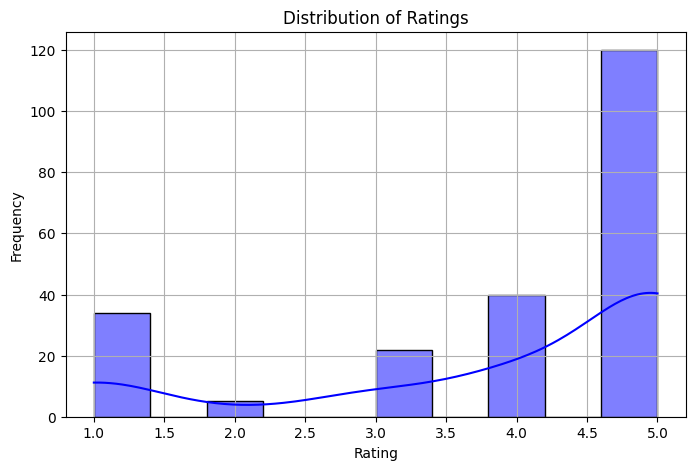

In [41]:

plt.figure(figsize=(8, 5))
sns.histplot(data['Rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


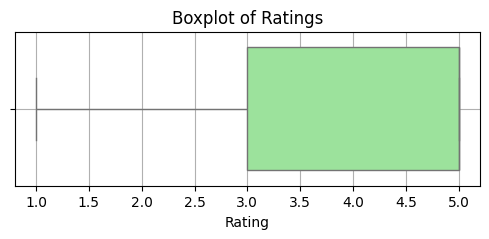

In [42]:

plt.figure(figsize=(6, 2))
sns.boxplot(x=data['Rating'], color='lightgreen')
plt.title('Boxplot of Ratings')
plt.xlabel('Rating')
plt.grid(True)
plt.show()


C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\3599722348.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=data, palette='pastel')


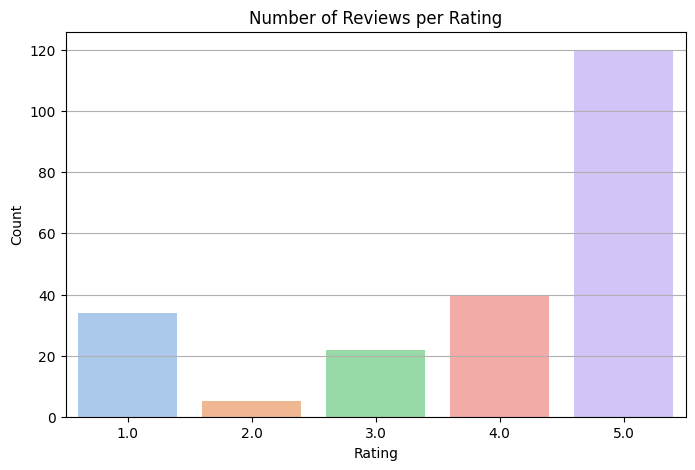

In [43]:

plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=data, palette='pastel')
plt.title('Number of Reviews per Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\2103545872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_df, x='frequency', y='word', palette='viridis')


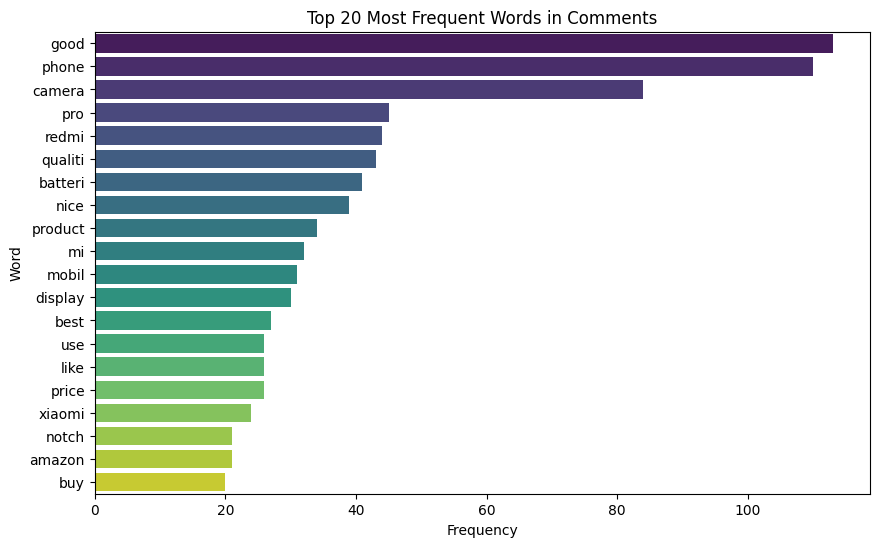

In [44]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(data['Comments'].dropna().astype(str))
word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({'word': words, 'frequency': word_freq})
freq_df = freq_df.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=freq_df, x='frequency', y='word', palette='viridis')
plt.title('Top 20 Most Frequent Words in Comments')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Unigram and bigram vectorization
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=1000)
X_ngrams = vectorizer.fit_transform(data['Comments'].dropna().astype(str))

# Create DataFrame of top n-grams
ngrams_df = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out())


In [46]:
from textblob import TextBlob

# Extract top aspects (as tags)
aspect_phrases = []
for comment in data['Comments'].dropna().astype(str):
    aspect_phrases.extend(TextBlob(comment).noun_phrases)

# Choose top N aspects to encode as binary tags
from collections import Counter
top_aspects = [aspect for aspect, count in Counter(aspect_phrases).most_common(20)]

# Encode presence of aspects as binary columns
for aspect in top_aspects:
    data[f'aspect_{aspect.replace(" ", "_")}'] = data['Comments'].fillna('').apply(
    lambda x: int(aspect in (' '.join(x).lower() if isinstance(x, list) else x.lower()))
)



In [ ]:
from nltk.sentiment.util import mark_negation
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')

# Sentiment lexicon-based features
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

def lexicon_features(text):
    # If it's a list (e.g., already tokenized), join it into a sentence
    if isinstance(text, list):
        text = ' '.join(text)
    words = word_tokenize(text.lower())
    words = mark_negation(words)
    pos_count = sum(1 for w in words if w in pos_words)
    neg_count = sum(1 for w in words if w in neg_words)
    return pd.Series([pos_count, neg_count])

data[['lexicon_pos_count', 'lexicon_neg_count']] = data['Comments'].fillna('').apply(lexicon_features)


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\opinion_lexicon.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# TF-IDF features
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=500, stop_words='english')
X_tfidf = tfidf.fit_transform(data['Comments'].fillna('').astype(str))

# Select engineered features to combine
engineered_features = data[
    [col for col in data.columns if col.startswith('aspect_')] +
    ['lexicon_pos_count', 'lexicon_neg_count']
].fillna(0)

# Scale numeric features
scaler = StandardScaler()
X_engineered = scaler.fit_transform(engineered_features)

# Combine TF-IDF with engineered features
from scipy.sparse import csr_matrix
X_final = hstack([X_tfidf, csr_matrix(X_engineered)])

print(f"Final feature matrix shape: {X_final.shape}")


Final feature matrix shape: (221, 522)


In [49]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(data['Comments'].fillna('').astype(str))

print(f"BoW Shape: {X_bow.shape}")


BoW Shape: (221, 862)


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(data['Comments'].fillna('').astype(str))

print(f"TF-IDF Shape: {X_tfidf.shape}")


TF-IDF Shape: (221, 1000)


In [ ]:
# Load GloVe 100d embeddings (this may take time)
glove = api.load("glove-wiki-gigaword-100")

def get_avg_glove_vector(text):
    if isinstance(text, list):
        text = ' '.join(text)
    words = word_tokenize(text.lower())
    vectors = [glove[w] for w in words if w in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# Generate average vectors for each comment
embeddings = data['Comments'].fillna('').apply(get_avg_glove_vector)
X_glove = np.vstack(embeddings.values)

print(f"GloVe Embedding Shape: {X_glove.shape}")


GloVe Embedding Shape: (221, 100)


C:\Users\madhu\AppData\Local\Temp\ipykernel_181368\3164409587.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=target_col, palette='Set2')


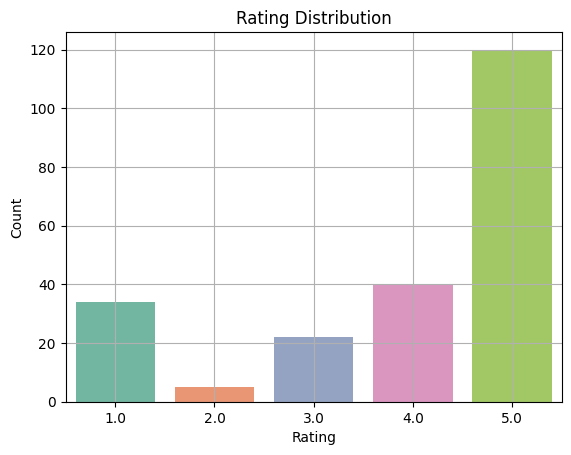

Rating
5.0    54.3
4.0    18.1
1.0    15.4
3.0    10.0
2.0     2.3
Name: proportion, dtype: float64


In [54]:
# Assuming sentiment or rating is your target
target_col = 'Predicted Sentiment' if 'Predicted Sentiment' in data.columns else 'Rating'

# Plot distribution
sns.countplot(data=data, x=target_col, palette='Set2')
plt.title(f'{target_col} Distribution')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Show class ratios
print(data[target_col].value_counts(normalize=True).round(3) * 100)


In [55]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data[target_col] == data[target_col].value_counts().idxmax()]
df_minority = data[data[target_col] != data[target_col].value_counts().idxmax()]

# Downsample majority
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combine and shuffle
data_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)


In [56]:
# Use oversample for smaller classes
df_list = []
max_size = data[target_col].value_counts().max()

for class_label in data[target_col].unique():
    df_class = data[data[target_col] == class_label]
    df_class_upsampled = resample(df_class, replace=True, n_samples=max_size, random_state=42)
    df_list.append(df_class_upsampled)

data_oversampled = pd.concat(df_list).sample(frac=1, random_state=42)


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Apply VADER to comments
# Ensure all comments are strings before analysis
data['vader_compound'] = data['Comments'].fillna('').apply(
    lambda x: sia.polarity_scores(' '.join(x) if isinstance(x, list) else x)['compound']
)


# Assign labels
data['vader_sentiment'] = data['vader_compound'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\madhu\AppData\Roaming\nltk_data...


In [58]:
# Apply TextBlob to comments
data['textblob_polarity'] = data['Comments'].fillna('').apply(
    lambda x: TextBlob(' '.join(x) if isinstance(x, list) else x).sentiment.polarity
)
# Assign labels
data['textblob_sentiment'] = data['textblob_polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


In [60]:
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

def lexicon_sentiment(text):
    if isinstance(text, list):
        text = ' '.join(text)
    words = mark_negation(word_tokenize(text.lower()))
    pos = sum(1 for w in words if w in pos_words)
    neg = sum(1 for w in words if w in neg_words)
    if pos > neg:
        return 'Positive'
    elif neg > pos:
        return 'Negative'
    else:
        return 'Neutral'

data['lexicon_sentiment'] = data['Comments'].fillna('').apply(lexicon_sentiment)


In [61]:
methods = ['vader_sentiment', 'textblob_sentiment', 'lexicon_sentiment']
for method in methods:
    print(f"\n{method} distribution:")
    print(data[method].value_counts())



vader_sentiment distribution:
vader_sentiment
Positive    161
Neutral      39
Negative     21
Name: count, dtype: int64

textblob_sentiment distribution:
textblob_sentiment
Positive    153
Neutral      53
Negative     15
Name: count, dtype: int64

lexicon_sentiment distribution:
lexicon_sentiment
Positive    152
Neutral      47
Negative     22
Name: count, dtype: int64


In [62]:
# Select sample feedback (e.g., first 10 rows)
sample = data[['Comments', 'vader_compound', 'textblob_polarity']].copy().head(10)

# Normalize polarity scores to a common scale if needed
sample['vader_label'] = data['vader_sentiment'].head(10)
sample['textblob_label'] = data['textblob_sentiment'].head(10)
sample['lexicon_label'] = data['lexicon_sentiment'].head(10)

# Display table
sample[['Comments', 'vader_compound', 'vader_label',
        'textblob_polarity', 'textblob_label',
        'lexicon_label']]


,Comments,vader_compound,vader_label,textblob_polarity,textblob_label,lexicon_label
0,"[anoth, midrang, killer, smartphon, xiaomi, ma...",0.9934,Positive,0.171602,Positive,Positive
1,"[ok, vri, small, size, mobil]",0.2960,Positive,0.125000,Positive,Neutral
2,"[quit, good]",0.4404,Positive,0.700000,Positive,Positive
3,"[redmi, alway, king, budget, segmentand, yet, ...",0.9153,Positive,0.093403,Positive,Positive
4,"[worst, product, mi, hardcor, fan, mi, one, re...",-0.6705,Negative,-1.000000,Negative,Negative
5,"[prise, least, around, rs, low, light, photo, ...",0.9705,Positive,0.328571,Positive,Positive
6,"[pro, notch, display, dual, camera, face, unlo...",0.7650,Positive,0.383333,Positive,Positive
7,"[front, camera, poor, rest, thing, good]",-0.0516,Negative,0.150000,Positive,Neutral
8,[wooo],0.0000,Neutral,0.000000,Neutral,Neutral
9,"[realm, sub, brand, oppo, give, money, techi, ...",0.4404,Positive,0.233333,Positive,Positive


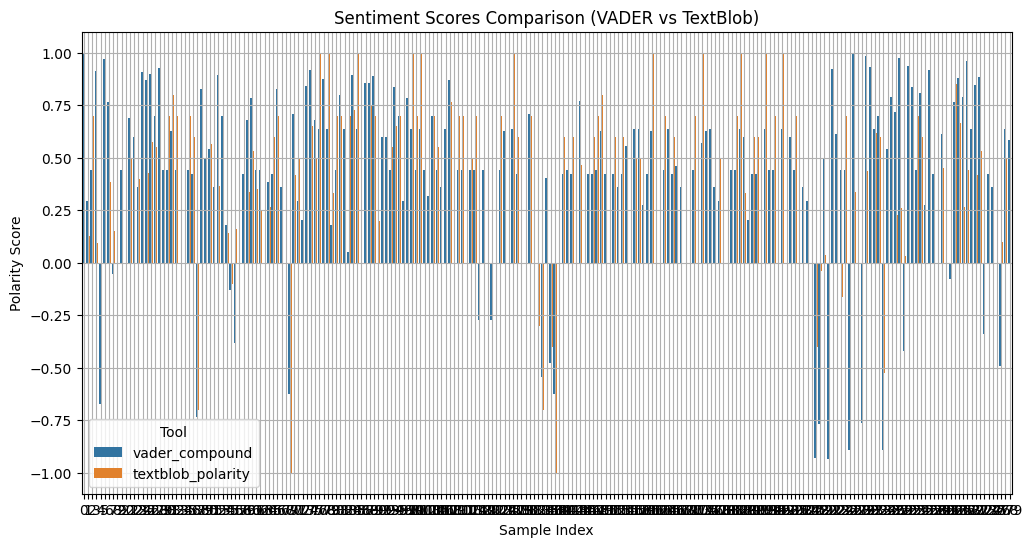

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt to long format for seaborn
scores_long = data[['vader_compound', 'textblob_polarity']].reset_index().melt(id_vars='index',
                                                                                var_name='Tool',
                                                                                value_name='Score')


# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_long, x='index', y='Score', hue='Tool')
plt.title('Sentiment Scores Comparison (VADER vs TextBlob)')
plt.xlabel('Sample Index')
plt.ylabel('Polarity Score')
plt.grid(True)
plt.show()


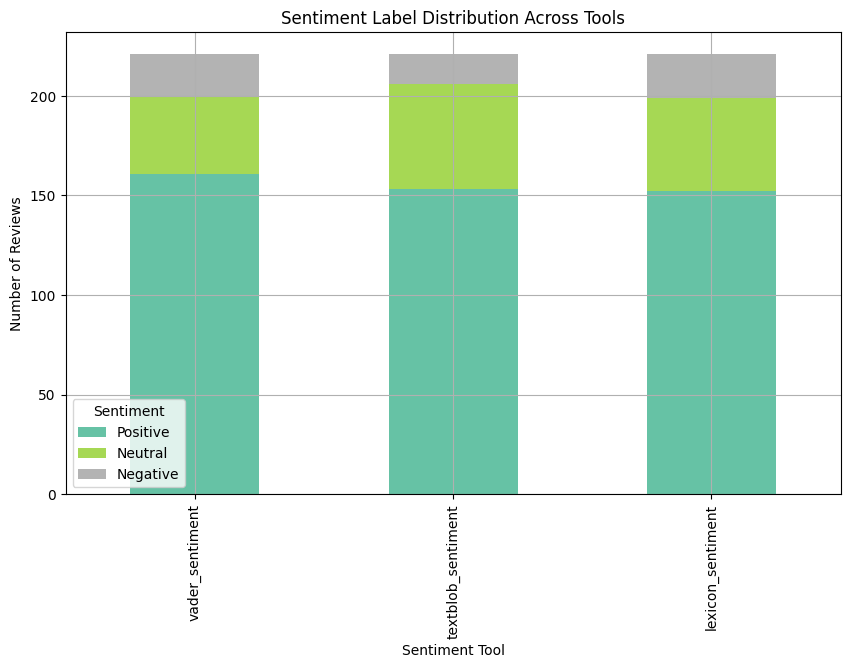

In [64]:
# Count sentiment labels for each tool
label_df = data[['vader_sentiment', 'textblob_sentiment', 'lexicon_sentiment']]
label_counts = label_df.apply(pd.Series.value_counts).T.fillna(0)

# Stacked bar chart
label_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Sentiment Label Distribution Across Tools')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment Tool')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()


In [65]:
# Filter rows where sentiment predictions differ
disagreements = data[
    (data['vader_sentiment'] != data['textblob_sentiment']) |
    (data['vader_sentiment'] != data['lexicon_sentiment']) |
    (data['textblob_sentiment'] != data['lexicon_sentiment'])
]

# Display sample disagreements
disagreements[['Comments', 'vader_sentiment', 'textblob_sentiment', 'lexicon_sentiment']].head(10)


,Comments,vader_sentiment,textblob_sentiment,lexicon_sentiment
1,"[ok, vri, small, size, mobil]",Positive,Positive,Neutral
7,"[front, camera, poor, rest, thing, good]",Negative,Positive,Neutral
22,"[like, everi, thing, fullscreen, video, play, ...",Positive,Neutral,Positive
23,"[pleas, buy, product, mobil, mi, face, type, i...",Positive,Positive,Negative
34,"[dual, g, think, new, mobil, buy, realm]",Neutral,Positive,Neutral
51,"[like, everyth, besid, display]",Positive,Neutral,Positive
55,"[worst, phone, mi, amazon, touch, good, didnot...",Negative,Negative,Positive
56,"[camera, qualiti, bedit, price, high, qualiti,...",Negative,Positive,Neutral
67,"[midrang, phone, notchand, brand, like, mi, au...",Positive,Neutral,Positive
71,[ok],Positive,Positive,Neutral


In [66]:
# Create a column with mode sentiment (majority vote)
from statistics import mode

def majority_sentiment(row):
    try:
        return mode([row['vader_sentiment'], row['textblob_sentiment'], row['lexicon_sentiment']])
    except:
        return 'No Consensus'

data['majority_sentiment'] = data[['vader_sentiment', 'textblob_sentiment', 'lexicon_sentiment']].apply(majority_sentiment, axis=1)

# Percentage of disagreements
total_reviews = len(data)
disagreements_count = (data['majority_sentiment'] == 'No Consensus').sum()
print(f"Disagreements: {disagreements_count} / {total_reviews} ({disagreements_count/total_reviews:.2%})")


Disagreements: 0 / 221 (0.00%)


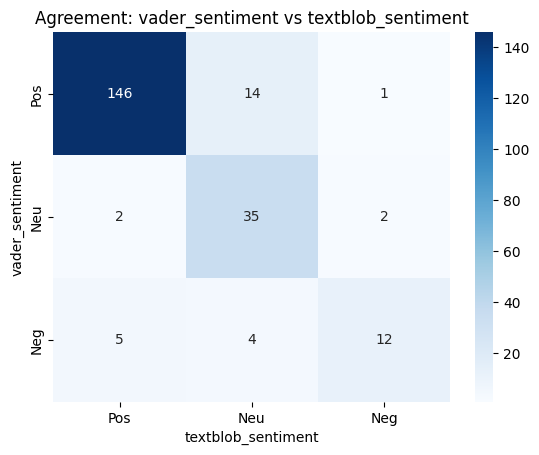

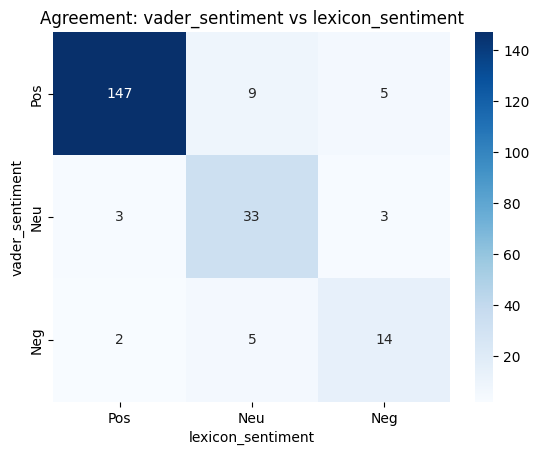

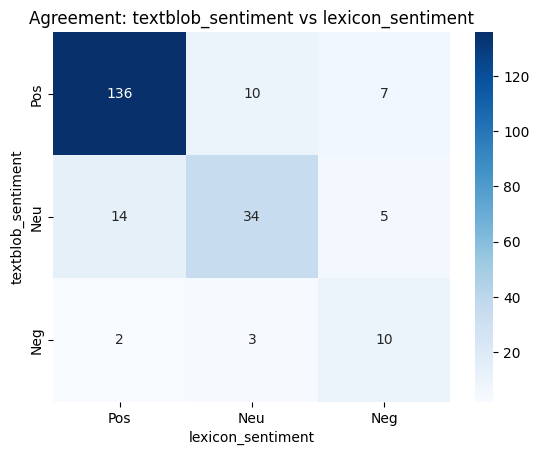

In [67]:
# Heatmap of pairwise agreement
import seaborn as sns
import matplotlib.pyplot as plt

# Pairwise agreement matrix
from sklearn.metrics import confusion_matrix

tools = ['vader_sentiment', 'textblob_sentiment', 'lexicon_sentiment']
for i in range(len(tools)):
    for j in range(i+1, len(tools)):
        cm = confusion_matrix(data[tools[i]], data[tools[j]], labels=['Positive', 'Neutral', 'Negative'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pos','Neu','Neg'], yticklabels=['Pos','Neu','Neg'])
        plt.title(f'Agreement: {tools[i]} vs {tools[j]}')
        plt.xlabel(tools[j])
        plt.ylabel(tools[i])
        plt.show()
